# 🎵 AST Training with GAN-Based Data Augmentation

## 📋 Overview
This notebook implements **Audio Spectrogram Transformer (AST)** training for music emotion recognition with **GAN-based data augmentation** to expand the DEAM dataset.

### Key Features:
- **Conditional GAN**: Generates synthetic spectrograms conditioned on valence/arousal
- **Data Expansion**: Increases dataset size from ~1800 to 5000+ samples
- **AST Architecture**: Vision Transformer adapted for audio spectrograms
- **Emotion Prediction**: Valence-Arousal (VA) continuous values

### Pipeline:
1. Load DEAM dataset and extract real spectrograms
2. Train Conditional GAN to generate synthetic spectrograms
3. Augment dataset with GAN-generated samples
4. Train AST model on expanded dataset
5. Evaluate on test set

## 1️⃣ Import Libraries

In [8]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import librosa.display

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
root = Path('/kaggle/input').resolve()
print(root.exists())
print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

True
✅ All libraries imported successfully!
PyTorch version: 2.6.0+cu124
Device: CUDA


## 2️⃣ Configuration & Hyperparameters

In [29]:
# ========================
# DATASET CONFIGURATION
# ========================
AUDIO_DIR = '/kaggle/input/deam-mediaeval-dataset-emotional-analysis-in-music/DEAM_audio/MEMD_audio/'
ANNOTATIONS_DIR = '/kaggle/input/deam-mediaeval-dataset-emotional-analysis-in-music/DEAM_Annotations/annotations/annotations averaged per song/song_level/'

# ========================
# AUDIO PROCESSING CONFIG
# ========================
SAMPLE_RATE = 22050          # Audio sampling rate (Hz)
DURATION = 30                # Audio clip duration (seconds)
N_MELS = 128                 # Number of mel-frequency bins
HOP_LENGTH = 512             # Hop length for STFT
N_FFT = 2048                 # FFT window size
FMIN = 20                    # Minimum frequency
FMAX = 8000                  # Maximum frequency

# ========================
# GAN CONFIGURATION
# ========================
LATENT_DIM = 100             # Dimension of GAN noise vector
CONDITION_DIM = 2            # Valence + Arousal
GAN_LR = 0.0002              # GAN learning rate
GAN_BETA1 = 0.5              # Adam beta1 for GAN
GAN_BETA2 = 0.999            # Adam beta2 for GAN
GAN_EPOCHS = 10              # GAN pre-training epochs
GAN_BATCH_SIZE = 32          # GAN batch size
NUM_SYNTHETIC = 3200         # Number of synthetic samples to generate

# ========================
# AST MODEL CONFIGURATION
# ========================
PATCH_SIZE = 16              # Size of each image patch (16x16)
EMBED_DIM = 384              # Embedding dimension
NUM_HEADS = 6                # Number of attention heads
NUM_LAYERS = 6               # Number of transformer layers
MLP_RATIO = 4                # MLP hidden dim = embed_dim * mlp_ratio
DROPOUT = 0.1                # Dropout rate

# ========================
# TRAINING CONFIGURATION
# ========================
BATCH_SIZE = 16              # AST training batch size
NUM_EPOCHS = 50               # AST training epochs (set to 5 as requested)
LEARNING_RATE = 1e-4         # AST learning rate
WEIGHT_DECAY = 0.05          # AdamW weight decay
TRAIN_SPLIT = 0.8            # Train/validation split ratio

# ========================
# SYSTEM CONFIGURATION
# ========================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OUTPUT_DIR = '/kaggle/working/augmented'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("=" * 50)
print("📊 CONFIGURATION SUMMARY")
print("=" * 50)
print(f"Device: {DEVICE}")
print(f"Audio Duration: {DURATION}s @ {SAMPLE_RATE}Hz")
print(f"Mel-Spectrogram: {N_MELS} bins")
print(f"\n🎨 GAN Configuration:")
print(f"  - Latent Dim: {LATENT_DIM}")
print(f"  - GAN Epochs: {GAN_EPOCHS}")
print(f"  - Synthetic Samples: {NUM_SYNTHETIC}")
print(f"\n🤖 AST Configuration:")
print(f"  - Patch Size: {PATCH_SIZE}x{PATCH_SIZE}")
print(f"  - Embed Dim: {EMBED_DIM}")
print(f"  - Num Heads: {NUM_HEADS}")
print(f"  - Num Layers: {NUM_LAYERS}")
print(f"\n🏋️ Training Configuration:")
print(f"  - AST Epochs: {NUM_EPOCHS}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print("=" * 50)

📊 CONFIGURATION SUMMARY
Device: cuda
Audio Duration: 30s @ 22050Hz
Mel-Spectrogram: 128 bins

🎨 GAN Configuration:
  - Latent Dim: 100
  - GAN Epochs: 10
  - Synthetic Samples: 3200

🤖 AST Configuration:
  - Patch Size: 16x16
  - Embed Dim: 384
  - Num Heads: 6
  - Num Layers: 6

🏋️ Training Configuration:
  - AST Epochs: 50
  - Batch Size: 16
  - Learning Rate: 0.0001


## 3️⃣ Load DEAM Dataset & Extract Real Spectrograms

In [18]:
# Load annotations (both static and dynamic contain song_id, valence, arousal)
# static_annotations_path = os.path.join(ANNOTATIONS_DIR, 'static_annotations.csv')
# dynamic_annotations_path = os.path.join(ANNOTATIONS_DIR, 'dynamic_annotations.csv')

static_2000 = root / 'static-annotations-1-2000' / 'static_annotations_averaged_songs_1_2000.csv'
static_2058 = root / 'static-annots-2058' / 'static_annots_2058.csv'
df1 = pd.read_csv(static_2000)
df2 = pd.read_csv(static_2058)

df_annotations = pd.concat([df1, df2], axis=0)

# Try to load both annotation files
# if os.path.exists(static_annotations_path):
#     df_annotations = pd.read_csv(static_annotations_path)
#     print(f"✅ Loaded static annotations: {len(df_annotations)} songs")
# elif os.path.exists(dynamic_annotations_path):
#     df_annotations = pd.read_csv(dynamic_annotations_path)
#     print(f"✅ Loaded dynamic annotations: {len(df_annotations)} songs")
# else:
#     # Fallback: Load any CSV in the directory
#     csv_files = glob.glob(os.path.join(ANNOTATIONS_DIR, '*.csv'))
#     if csv_files:
#         df_annotations = pd.read_csv(csv_files[0])
#         print(f"✅ Loaded annotations from {os.path.basename(csv_files[0])}: {len(df_annotations)} songs")
#     else:
#         raise FileNotFoundError(f"No annotation files found in {ANNOTATIONS_DIR}")

# Clean column names (remove whitespace)
df_annotations.columns = df_annotations.columns.str.strip()

# Display first few rows
print("\n📊 Annotation Sample:")
print(df_annotations.head())
print(f"\nColumns: {list(df_annotations.columns)}")

# Check for audio files
audio_files = glob.glob(os.path.join(AUDIO_DIR, '*.mp3'))
print(f"\n🎵 Found {len(audio_files)} audio files")

# Extract spectrograms from real data for GAN training
print("\n🔊 Extracting spectrograms from real audio...")

def extract_melspectrogram(audio_path, sr=SAMPLE_RATE, duration=DURATION):
    """Extract mel-spectrogram from audio file"""
    try:
        # Load audio
        y, _ = librosa.load(audio_path, sr=sr, duration=duration)
        
        # Compute mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=y, sr=sr, n_mels=N_MELS, n_fft=N_FFT, 
            hop_length=HOP_LENGTH, fmin=FMIN, fmax=FMAX
        )
        
        # Convert to log scale (dB)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Normalize to [-1, 1]
        mel_spec_norm = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)
        
        return mel_spec_norm
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Extract spectrograms and labels
real_spectrograms = []
real_labels = []

for idx, row in tqdm(df_annotations.iterrows(), total=len(df_annotations), desc="Extracting spectrograms"):
    # Get song_id and construct audio path
    song_id = str(int(row['song_id']))
    audio_path = os.path.join(AUDIO_DIR, f"{song_id}.mp3")
    
    
    if not os.path.exists(audio_path):
        print(audio_path)
        continue
    
    # Extract spectrogram
    spec = extract_melspectrogram(audio_path)
    if spec is not None:
        real_spectrograms.append(spec)
        
        # Get valence and arousal (try different column name variations)
        valence = row.get('valence_mean', row.get('valence', 0.5))
        arousal = row.get('arousal_mean', row.get('arousal', 0.5))
        
        # Normalize to [-1, 1] range (assuming original is 1-9 scale)
        valence_norm = (valence - 5.0) / 4.0
        arousal_norm = (arousal - 5.0) / 4.0
        
        real_labels.append([valence_norm, arousal_norm])

# Convert to numpy arrays
real_spectrograms = np.array(real_spectrograms)  # Shape: (N, n_mels, time_steps)
real_labels = np.array(real_labels)              # Shape: (N, 2)

print(f"\n✅ Extracted {len(real_spectrograms)} spectrograms")
print(f"Spectrogram shape: {real_spectrograms.shape}")
print(f"Labels shape: {real_labels.shape}")
print(f"Spectrogram range: [{real_spectrograms.min():.2f}, {real_spectrograms.max():.2f}]")
print(f"Labels range: [{real_labels.min():.2f}, {real_labels.max():.2f}]")


📊 Annotation Sample:
   song_id  valence_mean  valence_std  arousal_mean  arousal_std
0        2           3.1         0.94           3.0         0.63
1        3           3.5         1.75           3.3         1.62
2        4           5.7         1.42           5.5         1.63
3        5           4.4         2.01           5.3         1.85
4        7           5.8         1.47           6.4         1.69

Columns: ['song_id', 'valence_mean', 'valence_std', 'arousal_mean', 'arousal_std']

🎵 Found 1802 audio files

🔊 Extracting spectrograms from real audio...


Extracting spectrograms:   0%|          | 0/1802 [00:00<?, ?it/s]


✅ Extracted 1802 spectrograms
Spectrogram shape: (1802, 128, 1292)
Labels shape: (1802, 2)
Spectrogram range: [-7.76, 6.59]
Labels range: [-0.85, 0.85]


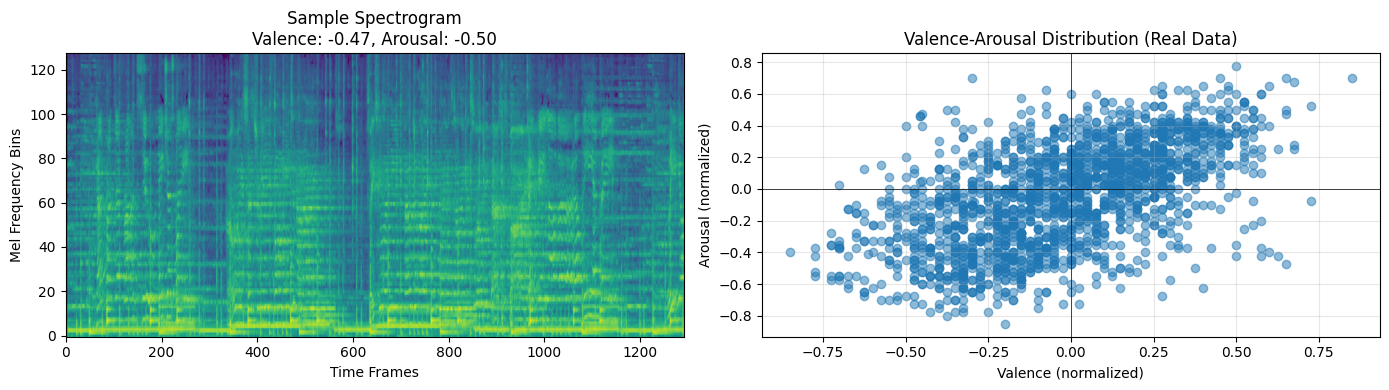

In [14]:
# Visualize sample spectrogram
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].imshow(real_spectrograms[0], aspect='auto', origin='lower', cmap='viridis')
axes[0].set_title(f'Sample Spectrogram\nValence: {real_labels[0][0]:.2f}, Arousal: {real_labels[0][1]:.2f}')
axes[0].set_xlabel('Time Frames')
axes[0].set_ylabel('Mel Frequency Bins')

axes[1].scatter(real_labels[:, 0], real_labels[:, 1], alpha=0.5)
axes[1].set_xlabel('Valence (normalized)')
axes[1].set_ylabel('Arousal (normalized)')
axes[1].set_title('Valence-Arousal Distribution (Real Data)')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='k', linewidth=0.5)
axes[1].axvline(0, color='k', linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'real_data_visualization.png'), dpi=150, bbox_inches='tight')
plt.show()

## 4️⃣ Conditional GAN Architecture

In [15]:
class SpectrogramGenerator(nn.Module):
    """
    Conditional GAN Generator for Mel-Spectrograms
    
    Takes:
        - Latent noise vector (z): Random noise from normal distribution
        - Condition (c): Valence and Arousal values [v, a]
    
    Generates:
        - Synthetic mel-spectrogram of shape (1, n_mels, time_steps)
    """
    def __init__(self, latent_dim=LATENT_DIM, condition_dim=CONDITION_DIM, 
                 n_mels=N_MELS, time_steps=1292):  # time_steps ≈ (30s * 22050) / 512
        super(SpectrogramGenerator, self).__init__()
        
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim
        self.n_mels = n_mels
        self.time_steps = time_steps
        
        # Initial projection: (latent + condition) -> feature map
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 256 * 16 * 20),
            nn.BatchNorm1d(256 * 16 * 20),
            nn.ReLU(True)
        )
        
        # Convolutional upsampling layers
        self.conv_layers = nn.Sequential(
            # 256 x 16 x 20
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 128 x 32 x 40
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64 x 64 x 80
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # 32 x 128 x 160
            
            nn.ConvTranspose2d(32, 1, kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Tanh()  # Output in [-1, 1]
            # 1 x 128 x 1280 (close to target)
        )
        
    def forward(self, z, c):
        """
        Args:
            z: Latent noise, shape (batch, latent_dim)
            c: Condition (valence, arousal), shape (batch, condition_dim)
        Returns:
            Generated spectrogram, shape (batch, 1, n_mels, time_steps)
        """
        # Concatenate latent and condition
        x = torch.cat([z, c], dim=1)  # (batch, latent_dim + condition_dim)
        
        # Project and reshape
        x = self.fc(x)
        x = x.view(-1, 256, 16, 20)
        
        # Upsample through conv layers
        x = self.conv_layers(x)
        
        # Adjust to exact time_steps if needed
        if x.shape[-1] != self.time_steps:
            x = F.interpolate(x, size=(self.n_mels, self.time_steps), mode='bilinear', align_corners=False)
        
        return x


class SpectrogramDiscriminator(nn.Module):
    """
    Conditional GAN Discriminator for Mel-Spectrograms
    
    Takes:
        - Spectrogram: Real or fake spectrogram (1, n_mels, time_steps)
        - Condition: Valence and Arousal values [v, a]
    
    Outputs:
        - Probability that spectrogram is real (scalar)
    """
    def __init__(self, condition_dim=CONDITION_DIM, n_mels=N_MELS, time_steps=1292):
        super(SpectrogramDiscriminator, self).__init__()
        
        self.n_mels = n_mels
        self.time_steps = time_steps
        
        # Convolutional layers for spectrogram
        self.conv_layers = nn.Sequential(
            # Input: 1 x 128 x 1292
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # 32 x 64 x 646
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 32 x 323
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 16 x 161
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 8 x 80
        )
        
        # Calculate flattened size after convolutions
        conv_output_size = 256 * 8 * 80  # Approximate
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size + condition_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()  # Output probability [0, 1]
        )
        
    def forward(self, spec, c):
        """
        Args:
            spec: Spectrogram, shape (batch, 1, n_mels, time_steps)
            c: Condition (valence, arousal), shape (batch, condition_dim)
        Returns:
            Probability of being real, shape (batch, 1)
        """
        # Extract features from spectrogram
        features = self.conv_layers(spec)
        features = features.view(features.size(0), -1)
        
        # Concatenate with condition
        x = torch.cat([features, c], dim=1)
        
        # Classify
        output = self.fc(x)
        return output


# Initialize models
time_steps = real_spectrograms.shape[2]  # Get actual time steps from data
generator = SpectrogramGenerator(
    latent_dim=LATENT_DIM, 
    condition_dim=CONDITION_DIM, 
    n_mels=N_MELS, 
    time_steps=time_steps
).to(DEVICE)

discriminator = SpectrogramDiscriminator(
    condition_dim=CONDITION_DIM, 
    n_mels=N_MELS, 
    time_steps=time_steps
).to(DEVICE)

# Print model summaries
print("=" * 60)
print("🎨 GENERATOR ARCHITECTURE")
print("=" * 60)
print(generator)
print(f"\nTotal parameters: {sum(p.numel() for p in generator.parameters()):,}")

print("\n" + "=" * 60)
print("🔍 DISCRIMINATOR ARCHITECTURE")
print("=" * 60)
print(discriminator)
print(f"\nTotal parameters: {sum(p.numel() for p in discriminator.parameters()):,}")
print("=" * 60)

🎨 GENERATOR ARCHITECTURE
SpectrogramGenerator(
  (fc): Sequential(
    (0): Linear(in_features=102, out_features=81920, bias=True)
    (1): BatchNorm1d(81920, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_layers): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(1, 8), stride=(1, 8))
    (10): Tanh()
  )
)

Total parameters: 

## 5️⃣ Train Conditional GAN


🚀 Starting GAN Training...



Epoch 1/10:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch [1/10] | D Loss: 0.0393 | G Loss: 94.7584


Epoch 2/10:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch [2/10] | D Loss: 0.0000 | G Loss: 98.7056


Epoch 3/10:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch [3/10] | D Loss: 0.0000 | G Loss: 98.6278


Epoch 4/10:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch [4/10] | D Loss: 0.0000 | G Loss: 98.7791


Epoch 5/10:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch [5/10] | D Loss: 0.0000 | G Loss: 98.7287


Epoch 6/10:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch [6/10] | D Loss: 0.0000 | G Loss: 98.7447


Epoch 7/10:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch [7/10] | D Loss: 0.0000 | G Loss: 98.7083


Epoch 8/10:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch [8/10] | D Loss: 0.0000 | G Loss: 98.6816


Epoch 9/10:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch [9/10] | D Loss: 0.0000 | G Loss: 98.4949


Epoch 10/10:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch [10/10] | D Loss: 0.0000 | G Loss: 98.5791

✅ GAN Training Complete!



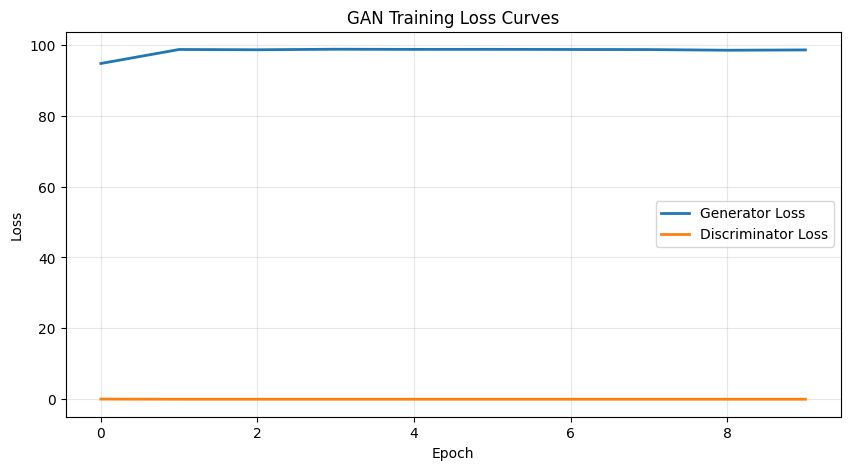

✅ GAN models saved!


In [16]:
# Prepare data for GAN training
real_specs_tensor = torch.FloatTensor(real_spectrograms).unsqueeze(1).to(DEVICE)  # (N, 1, n_mels, time_steps)
real_labels_tensor = torch.FloatTensor(real_labels).to(DEVICE)  # (N, 2)

gan_dataset = torch.utils.data.TensorDataset(real_specs_tensor, real_labels_tensor)
gan_loader = DataLoader(gan_dataset, batch_size=GAN_BATCH_SIZE, shuffle=True, drop_last=True)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=GAN_LR, betas=(GAN_BETA1, GAN_BETA2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=GAN_LR, betas=(GAN_BETA1, GAN_BETA2))

# Training loop
print("\n🚀 Starting GAN Training...\n")

g_losses = []
d_losses = []

for epoch in range(GAN_EPOCHS):
    epoch_g_loss = 0
    epoch_d_loss = 0
    
    for i, (real_specs, conditions) in enumerate(tqdm(gan_loader, desc=f"Epoch {epoch+1}/{GAN_EPOCHS}")):
        batch_size = real_specs.size(0)
        
        # Real and fake labels
        real_labels = torch.ones(batch_size, 1).to(DEVICE)
        fake_labels = torch.zeros(batch_size, 1).to(DEVICE)
        
        # ==================
        # Train Discriminator
        # ==================
        optimizer_D.zero_grad()
        
        # Real spectrograms
        real_output = discriminator(real_specs, conditions)
        d_loss_real = criterion(real_output, real_labels)
        
        # Fake spectrograms
        z = torch.randn(batch_size, LATENT_DIM).to(DEVICE)
        fake_specs = generator(z, conditions)
        fake_output = discriminator(fake_specs.detach(), conditions)
        d_loss_fake = criterion(fake_output, fake_labels)
        
        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()
        
        # ==================
        # Train Generator
        # ==================
        optimizer_G.zero_grad()
        
        # Generate fake spectrograms
        z = torch.randn(batch_size, LATENT_DIM).to(DEVICE)
        fake_specs = generator(z, conditions)
        
        # Generator tries to fool discriminator
        fake_output = discriminator(fake_specs, conditions)
        g_loss = criterion(fake_output, real_labels)
        
        g_loss.backward()
        optimizer_G.step()
        
        # Accumulate losses
        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
    
    # Average losses for epoch
    epoch_g_loss /= len(gan_loader)
    epoch_d_loss /= len(gan_loader)
    
    g_losses.append(epoch_g_loss)
    d_losses.append(epoch_d_loss)
    
    print(f"Epoch [{epoch+1}/{GAN_EPOCHS}] | D Loss: {epoch_d_loss:.4f} | G Loss: {epoch_g_loss:.4f}")

print("\n✅ GAN Training Complete!\n")

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss', linewidth=2)
plt.plot(d_losses, label='Discriminator Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUTPUT_DIR, 'gan_training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

# Save trained GAN models
torch.save(generator.state_dict(), os.path.join(OUTPUT_DIR, 'generator.pth'))
torch.save(discriminator.state_dict(), os.path.join(OUTPUT_DIR, 'discriminator.pth'))
print("✅ GAN models saved!")

## 6️⃣ Generate Synthetic Spectrograms

🎨 Generating 3200 synthetic spectrograms...



Generating:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Generated 3200 synthetic spectrograms
Synthetic spectrogram shape: (3200, 128, 1292)
Synthetic labels shape: (3200, 2)


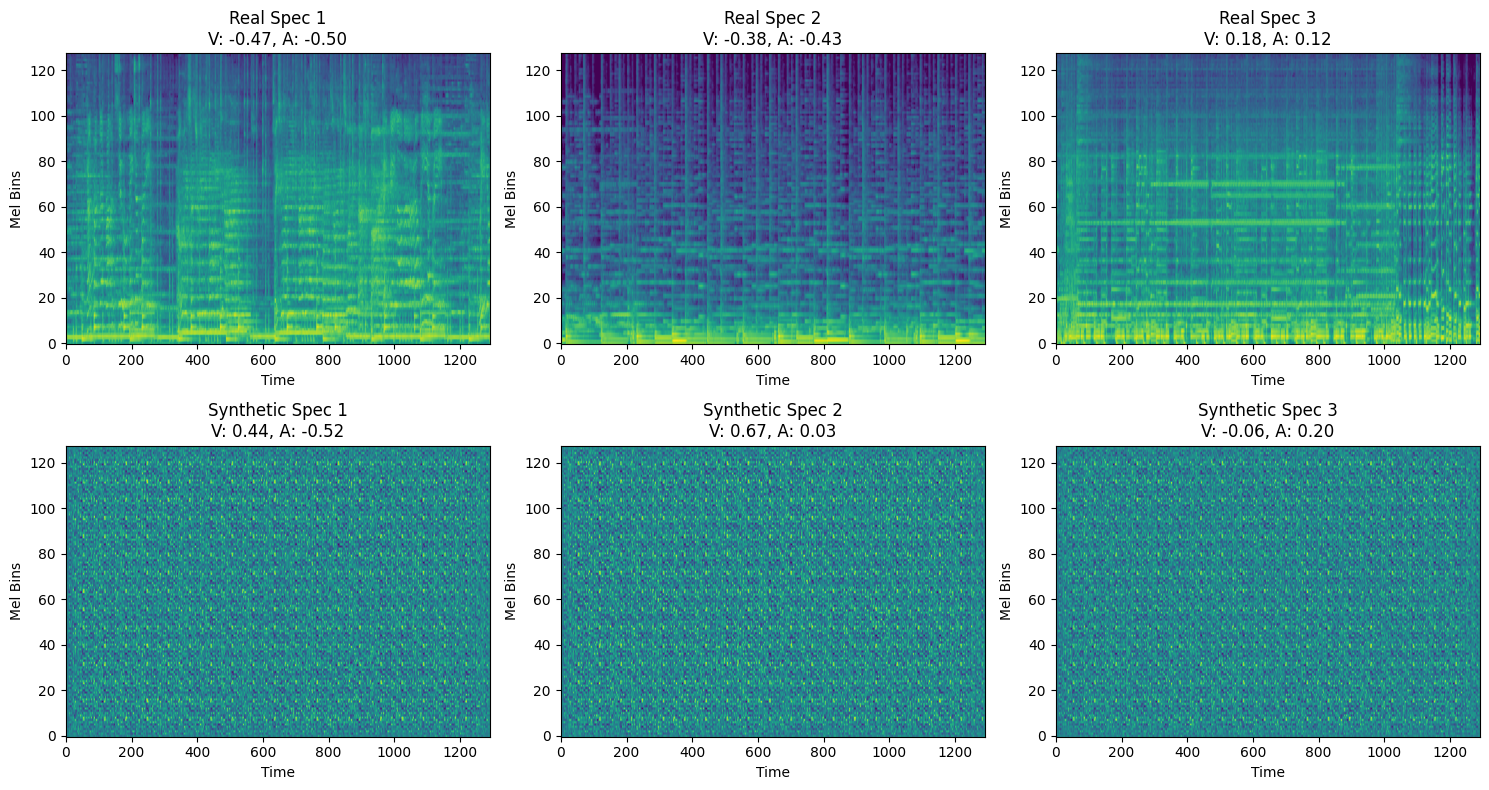

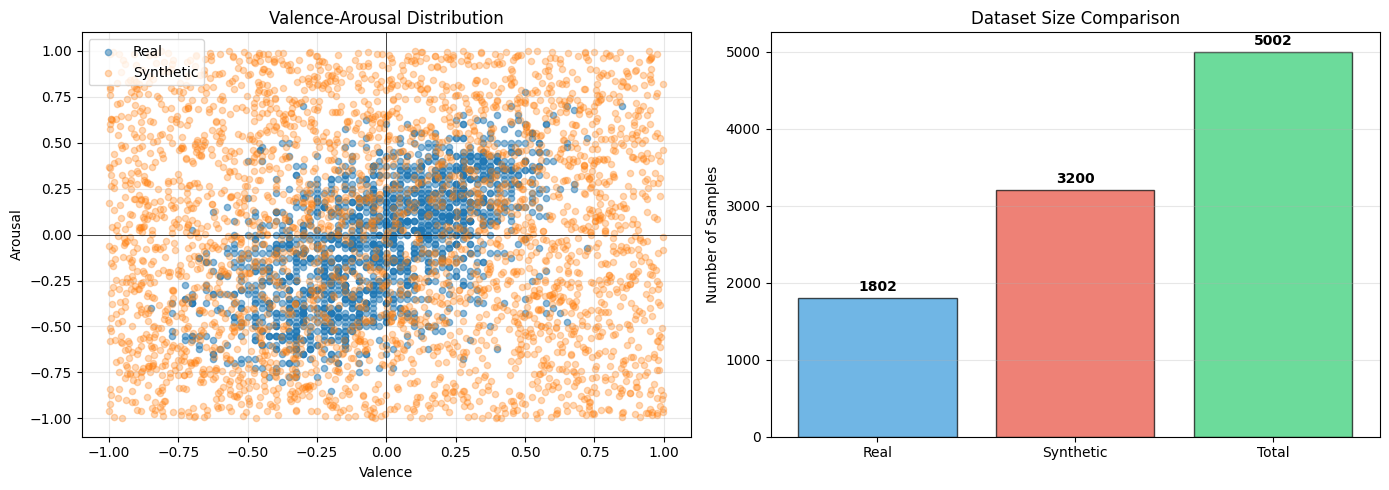


📊 Dataset Statistics:
  - Real samples: 1802
  - Synthetic samples: 3200
  - Total samples: 5002
  - Data augmentation factor: 2.78x


In [24]:
print(f"🎨 Generating {NUM_SYNTHETIC} synthetic spectrograms...\n")

generator.eval()
synthetic_spectrograms = []
synthetic_labels = []

with torch.no_grad():
    num_batches = NUM_SYNTHETIC // GAN_BATCH_SIZE
    
    for i in tqdm(range(num_batches), desc="Generating"):
        # Sample random latent vectors
        z = torch.randn(GAN_BATCH_SIZE, LATENT_DIM).to(DEVICE)
        
        # Sample random conditions (valence, arousal) in [-1, 1]
        random_conditions = torch.FloatTensor(GAN_BATCH_SIZE, 2).uniform_(-1, 1).to(DEVICE)
        
        # Generate spectrograms
        fake_specs = generator(z, random_conditions)
        
        # Store results
        synthetic_spectrograms.append(fake_specs.cpu().numpy())
        synthetic_labels.append(random_conditions.cpu().numpy())

# Concatenate all batches
synthetic_spectrograms = np.concatenate(synthetic_spectrograms, axis=0)  # (NUM_SYNTHETIC, 1, n_mels, time_steps)
synthetic_labels = np.concatenate(synthetic_labels, axis=0)  # (NUM_SYNTHETIC, 2)

# Remove channel dimension for consistency with real data
synthetic_spectrograms = synthetic_spectrograms.squeeze(1)  # (NUM_SYNTHETIC, n_mels, time_steps)

print(f"✅ Generated {len(synthetic_spectrograms)} synthetic spectrograms")
print(f"Synthetic spectrogram shape: {synthetic_spectrograms.shape}")
print(f"Synthetic labels shape: {synthetic_labels.shape}")

# Visualize synthetic vs real spectrograms
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Real spectrograms
for i in range(3):
    axes[0, i].imshow(real_spectrograms[i], aspect='auto', origin='lower', cmap='viridis')
    axes[0, i].set_title(f'Real Spec {i+1}\nV: {real_labels[i][0]:.2f}, A: {real_labels[i][1]:.2f}')
    axes[0, i].set_xlabel('Time')
    axes[0, i].set_ylabel('Mel Bins')

# Synthetic spectrograms
for i in range(3):
    axes[1, i].imshow(synthetic_spectrograms[i], aspect='auto', origin='lower', cmap='viridis')
    axes[1, i].set_title(f'Synthetic Spec {i+1}\nV: {synthetic_labels[i][0]:.2f}, A: {synthetic_labels[i][1]:.2f}')
    axes[1, i].set_xlabel('Time')
    axes[1, i].set_ylabel('Mel Bins')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'real_vs_synthetic_spectrograms.png'), dpi=150, bbox_inches='tight')
plt.show()

# Compare distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Valence-Arousal distribution
axes[0].scatter(real_labels[:, 0], real_labels[:, 1], alpha=0.5, label='Real', s=20)
axes[0].scatter(synthetic_labels[:, 0], synthetic_labels[:, 1], alpha=0.3, label='Synthetic', s=20)
axes[0].set_xlabel('Valence')
axes[0].set_ylabel('Arousal')
axes[0].set_title('Valence-Arousal Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='k', linewidth=0.5)
axes[0].axvline(0, color='k', linewidth=0.5)

# Dataset size comparison
sizes = [len(real_spectrograms), len(synthetic_spectrograms), 
         len(real_spectrograms) + len(synthetic_spectrograms)]
labels = ['Real', 'Synthetic', 'Total']
colors = ['#3498db', '#e74c3c', '#2ecc71']
axes[1].bar(labels, sizes, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('Dataset Size Comparison')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(sizes):
    axes[1].text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'augmented_dataset_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Dataset Statistics:")
print(f"  - Real samples: {len(real_spectrograms)}")
print(f"  - Synthetic samples: {len(synthetic_spectrograms)}")
print(f"  - Total samples: {len(real_spectrograms) + len(synthetic_spectrograms)}")
print(f"  - Data augmentation factor: {(len(real_spectrograms) + len(synthetic_spectrograms)) / len(real_spectrograms):.2f}x")

In [23]:
real_labels.shape, real_labels[0][1], real_labels[1]

((1802, 2), -0.5, array([-0.375, -0.425]))

## 7️⃣ Create Augmented Dataset for AST Training

In [25]:
class AugmentedSpectrogramDataset(Dataset):
    """
    PyTorch Dataset for Augmented Spectrograms (Real + GAN-Generated)
    
    Combines real and synthetic spectrograms for AST training.
    Applies SpecAugment (frequency/time masking) during training.
    """
    def __init__(self, spectrograms, labels, augment=True):
        """
        Args:
            spectrograms: numpy array of shape (N, n_mels, time_steps)
            labels: numpy array of shape (N, 2) - [valence, arousal]
            augment: Whether to apply SpecAugment
        """
        self.spectrograms = torch.FloatTensor(spectrograms)
        self.labels = torch.FloatTensor(labels)
        self.augment = augment
        
    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):
        spec = self.spectrograms[idx]  # (n_mels, time_steps)
        label = self.labels[idx]  # (2,)
        
        # Apply SpecAugment during training
        if self.augment:
            spec = self.spec_augment(spec)
        
        # Add channel dimension: (1, n_mels, time_steps)
        spec = spec.unsqueeze(0)
        
        return spec, label
    
    def spec_augment(self, spec, freq_mask_param=20, time_mask_param=40, num_masks=2):
        """
        Apply SpecAugment: random frequency and time masking
        
        Args:
            spec: Spectrogram tensor (n_mels, time_steps)
            freq_mask_param: Maximum frequency mask width
            time_mask_param: Maximum time mask width
            num_masks: Number of masks to apply
        """
        spec = spec.clone()
        n_mels, time_steps = spec.shape
        
        # Frequency masking
        for _ in range(num_masks):
            f = np.random.randint(0, freq_mask_param)
            f0 = np.random.randint(0, n_mels - f)
            spec[f0:f0+f, :] = 0
        
        # Time masking
        for _ in range(num_masks):
            t = np.random.randint(0, time_mask_param)
            t0 = np.random.randint(0, time_steps - t)
            spec[:, t0:t0+t] = 0
        
        return spec


# Combine real and synthetic data
print("📦 Creating augmented dataset...")

all_spectrograms = np.concatenate([real_spectrograms, synthetic_spectrograms], axis=0)
all_labels = np.concatenate([real_labels, synthetic_labels], axis=0)

print(f"✅ Combined dataset created:")
print(f"  - Total samples: {len(all_spectrograms)}")
print(f"  - Spectrogram shape: {all_spectrograms.shape}")
print(f"  - Labels shape: {all_labels.shape}")

# Create full dataset
full_dataset = AugmentedSpectrogramDataset(all_spectrograms, all_labels, augment=True)

# Split into train and validation
train_size = int(TRAIN_SPLIT * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create validation dataset without augmentation
val_dataset.dataset.augment = False

print(f"\n📊 Dataset Split:")
print(f"  - Training samples: {len(train_dataset)}")
print(f"  - Validation samples: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\n✅ Data loaders created!")
print(f"  - Training batches: {len(train_loader)}")
print(f"  - Validation batches: {len(val_loader)}")

📦 Creating augmented dataset...
✅ Combined dataset created:
  - Total samples: 5002
  - Spectrogram shape: (5002, 128, 1292)
  - Labels shape: (5002, 2)

📊 Dataset Split:
  - Training samples: 4001
  - Validation samples: 1001

✅ Data loaders created!
  - Training batches: 251
  - Validation batches: 63


## 8️⃣ Audio Spectrogram Transformer (AST) Model

In [26]:
class PatchEmbedding(nn.Module):
    """Convert spectrogram into patches and embed them"""
    def __init__(self, img_size=(128, 1292), patch_size=16, in_channels=1, embed_dim=384):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size[0] // patch_size) * (img_size[1] // patch_size)
        
        # Convolutional patch embedding
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        # x: (batch, 1, height, width)
        x = self.proj(x)  # (batch, embed_dim, n_patches_h, n_patches_w)
        x = x.flatten(2)  # (batch, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (batch, n_patches, embed_dim)
        return x


class MultiHeadAttention(nn.Module):
    """Multi-head self-attention mechanism"""
    def __init__(self, embed_dim=384, num_heads=6, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size, n_patches, embed_dim = x.shape
        
        # Generate Q, K, V
        qkv = self.qkv(x)  # (batch, n_patches, 3*embed_dim)
        qkv = qkv.reshape(batch_size, n_patches, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch, num_heads, n_patches, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Attention scores
        attn = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention to values
        out = attn @ v  # (batch, num_heads, n_patches, head_dim)
        out = out.transpose(1, 2)  # (batch, n_patches, num_heads, head_dim)
        out = out.reshape(batch_size, n_patches, embed_dim)
        
        # Final projection
        out = self.proj(out)
        out = self.dropout(out)
        
        return out


class TransformerBlock(nn.Module):
    """Transformer encoder block with attention and MLP"""
    def __init__(self, embed_dim=384, num_heads=6, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # Attention with residual
        x = x + self.attn(self.norm1(x))
        
        # MLP with residual
        x = x + self.mlp(self.norm2(x))
        
        return x


class SpectrogramTransformer(nn.Module):
    """
    Audio Spectrogram Transformer (AST) for Emotion Recognition
    
    Based on Vision Transformer (ViT) architecture adapted for audio spectrograms.
    Predicts valence and arousal values from mel-spectrograms.
    """
    def __init__(self, img_size=(128, 1292), patch_size=16, in_channels=1, 
                 embed_dim=384, num_heads=6, num_layers=6, mlp_ratio=4, dropout=0.1):
        super().__init__()
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        n_patches = self.patch_embed.n_patches
        
        # CLS token for classification
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Positional embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer encoder blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(num_layers)
        ])
        
        # Final normalization
        self.norm = nn.LayerNorm(embed_dim)
        
        # Regression head for valence and arousal
        self.head = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, 2)  # Valence and Arousal
        )
        
        # Initialize weights
        nn.init.normal_(self.cls_token, std=0.02)
        nn.init.normal_(self.pos_embed, std=0.02)
        
    def forward(self, x):
        # x: (batch, 1, height, width)
        batch_size = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # (batch, n_patches, embed_dim)
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # (batch, n_patches + 1, embed_dim)
        
        # Add positional embedding
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Final normalization
        x = self.norm(x)
        
        # Use CLS token for prediction
        cls_output = x[:, 0]  # (batch, embed_dim)
        
        # Regression head
        output = self.head(cls_output)  # (batch, 2)
        
        return output


# Initialize model
img_height, img_width = all_spectrograms.shape[1], all_spectrograms.shape[2]

model = SpectrogramTransformer(
    img_size=(img_height, img_width),
    patch_size=PATCH_SIZE,
    in_channels=1,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    mlp_ratio=MLP_RATIO,
    dropout=DROPOUT
).to(DEVICE)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("=" * 60)
print("🤖 AUDIO SPECTROGRAM TRANSFORMER")
print("=" * 60)
print(f"Input size: ({img_height}, {img_width})")
print(f"Patch size: {PATCH_SIZE}x{PATCH_SIZE}")
print(f"Number of patches: {model.patch_embed.n_patches}")
print(f"Embedding dimension: {EMBED_DIM}")
print(f"Number of attention heads: {NUM_HEADS}")
print(f"Number of transformer layers: {NUM_LAYERS}")
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("=" * 60)

🤖 AUDIO SPECTROGRAM TRANSFORMER
Input size: (128, 1292)
Patch size: 16x16
Number of patches: 640
Embedding dimension: 384
Number of attention heads: 6
Number of transformer layers: 6

Total parameters: 11,091,842
Trainable parameters: 11,091,842


## 9️⃣ Train AST Model on Augmented Dataset

In [30]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# Concordance Correlation Coefficient (CCC) - evaluation metric
def concordance_correlation_coefficient(y_true, y_pred):
    """
    Calculate CCC for emotion prediction evaluation
    CCC measures agreement between predictions and ground truth
    """
    mean_true = torch.mean(y_true)
    mean_pred = torch.mean(y_pred)
    var_true = torch.var(y_true)
    var_pred = torch.var(y_pred)
    covariance = torch.mean((y_true - mean_true) * (y_pred - mean_pred))
    
    ccc = (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred) ** 2 + 1e-8)
    return ccc.item()

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for specs, labels in tqdm(loader, desc="Training", leave=False):
        specs, labels = specs.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(specs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_preds.append(outputs.detach().cpu())
        all_labels.append(labels.detach().cpu())
    
    # Calculate metrics
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    avg_loss = total_loss / len(loader)
    mae = F.l1_loss(all_preds, all_labels).item()
    ccc_valence = concordance_correlation_coefficient(all_labels[:, 0], all_preds[:, 0])
    ccc_arousal = concordance_correlation_coefficient(all_labels[:, 1], all_preds[:, 1])
    
    return avg_loss, mae, ccc_valence, ccc_arousal

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for specs, labels in tqdm(loader, desc="Validating", leave=False):
            specs, labels = specs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(specs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            all_preds.append(outputs.cpu())
            all_labels.append(labels.cpu())
    
    # Calculate metrics
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    avg_loss = total_loss / len(loader)
    mae = F.l1_loss(all_preds, all_labels).item()
    ccc_valence = concordance_correlation_coefficient(all_labels[:, 0], all_preds[:, 0])
    ccc_arousal = concordance_correlation_coefficient(all_labels[:, 1], all_preds[:, 1])
    
    return avg_loss, mae, ccc_valence, ccc_arousal, all_preds, all_labels

# Training loop
print("\n🚀 Starting AST Training on Augmented Dataset...\n")

history = {
    'train_loss': [], 'train_mae': [], 'train_ccc_v': [], 'train_ccc_a': [],
    'val_loss': [], 'val_mae': [], 'val_ccc_v': [], 'val_ccc_a': []
}

best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_mae, train_ccc_v, train_ccc_a = train_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )
    
    # Validate
    val_loss, val_mae, val_ccc_v, val_ccc_a, val_preds, val_labels = validate(
        model, val_loader, criterion, DEVICE
    )
    
    # Update learning rate
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_mae'].append(train_mae)
    history['train_ccc_v'].append(train_ccc_v)
    history['train_ccc_a'].append(train_ccc_a)
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)
    history['val_ccc_v'].append(val_ccc_v)
    history['val_ccc_a'].append(val_ccc_a)
    
    # Print metrics
    print(f"\n📊 Training Metrics:")
    print(f"  Loss: {train_loss:.4f} | MAE: {train_mae:.4f}")
    print(f"  CCC Valence: {train_ccc_v:.4f} | CCC Arousal: {train_ccc_a:.4f}")
    
    print(f"\n📊 Validation Metrics:")
    print(f"  Loss: {val_loss:.4f} | MAE: {val_mae:.4f}")
    print(f"  CCC Valence: {val_ccc_v:.4f} | CCC Arousal: {val_ccc_a:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_ast_model.pth'))
        print(f"\n✅ Best model saved! (Val Loss: {val_loss:.4f})")

print("\n" + "="*60)
print("✅ Training Complete!")
print("="*60)


🚀 Starting AST Training on Augmented Dataset...


Epoch 1/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.2396 | MAE: 0.3953
  CCC Valence: 0.0649 | CCC Arousal: 0.0925

📊 Validation Metrics:
  Loss: 0.2355 | MAE: 0.3933
  CCC Valence: 0.0709 | CCC Arousal: 0.1030

✅ Best model saved! (Val Loss: 0.2355)

Epoch 2/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.2366 | MAE: 0.3919
  CCC Valence: 0.0762 | CCC Arousal: 0.1039

📊 Validation Metrics:
  Loss: 0.2296 | MAE: 0.3846
  CCC Valence: 0.1066 | CCC Arousal: 0.1329

✅ Best model saved! (Val Loss: 0.2296)

Epoch 3/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.2326 | MAE: 0.3875
  CCC Valence: 0.0970 | CCC Arousal: 0.1254

📊 Validation Metrics:
  Loss: 0.2317 | MAE: 0.3861
  CCC Valence: 0.1261 | CCC Arousal: 0.1508

Epoch 4/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.2323 | MAE: 0.3871
  CCC Valence: 0.0924 | CCC Arousal: 0.1282

📊 Validation Metrics:
  Loss: 0.2311 | MAE: 0.3852
  CCC Valence: 0.1436 | CCC Arousal: 0.1821

Epoch 5/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.2315 | MAE: 0.3845
  CCC Valence: 0.1037 | CCC Arousal: 0.1440

📊 Validation Metrics:
  Loss: 0.2343 | MAE: 0.3905
  CCC Valence: 0.0570 | CCC Arousal: 0.0816

Epoch 6/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.2313 | MAE: 0.3844
  CCC Valence: 0.1048 | CCC Arousal: 0.1466

📊 Validation Metrics:
  Loss: 0.2276 | MAE: 0.3815
  CCC Valence: 0.0954 | CCC Arousal: 0.1351

✅ Best model saved! (Val Loss: 0.2276)

Epoch 7/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.2253 | MAE: 0.3773
  CCC Valence: 0.1245 | CCC Arousal: 0.1923

📊 Validation Metrics:
  Loss: 0.2140 | MAE: 0.3707
  CCC Valence: 0.1733 | CCC Arousal: 0.2704

✅ Best model saved! (Val Loss: 0.2140)

Epoch 8/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.2083 | MAE: 0.3612
  CCC Valence: 0.2119 | CCC Arousal: 0.3325

📊 Validation Metrics:
  Loss: 0.1883 | MAE: 0.3443
  CCC Valence: 0.3107 | CCC Arousal: 0.4548

✅ Best model saved! (Val Loss: 0.1883)

Epoch 9/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.1844 | MAE: 0.3350
  CCC Valence: 0.3148 | CCC Arousal: 0.4880

📊 Validation Metrics:
  Loss: 0.2042 | MAE: 0.3509
  CCC Valence: 0.3252 | CCC Arousal: 0.4021

Epoch 10/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.1697 | MAE: 0.3204
  CCC Valence: 0.3763 | CCC Arousal: 0.5637

📊 Validation Metrics:
  Loss: 0.1759 | MAE: 0.3351
  CCC Valence: 0.3125 | CCC Arousal: 0.4738

✅ Best model saved! (Val Loss: 0.1759)

Epoch 11/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.1529 | MAE: 0.3041
  CCC Valence: 0.4679 | CCC Arousal: 0.6208

📊 Validation Metrics:
  Loss: 0.1541 | MAE: 0.3125
  CCC Valence: 0.4400 | CCC Arousal: 0.5871

✅ Best model saved! (Val Loss: 0.1541)

Epoch 12/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.1302 | MAE: 0.2790
  CCC Valence: 0.6081 | CCC Arousal: 0.6712

📊 Validation Metrics:
  Loss: 0.1391 | MAE: 0.2898
  CCC Valence: 0.5793 | CCC Arousal: 0.6426

✅ Best model saved! (Val Loss: 0.1391)

Epoch 13/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.1172 | MAE: 0.2611
  CCC Valence: 0.6493 | CCC Arousal: 0.7256

📊 Validation Metrics:
  Loss: 0.1515 | MAE: 0.3075
  CCC Valence: 0.5220 | CCC Arousal: 0.5954

Epoch 14/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.1007 | MAE: 0.2440
  CCC Valence: 0.7237 | CCC Arousal: 0.7581

📊 Validation Metrics:
  Loss: 0.1261 | MAE: 0.2681
  CCC Valence: 0.6803 | CCC Arousal: 0.6999

✅ Best model saved! (Val Loss: 0.1261)

Epoch 15/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0942 | MAE: 0.2369
  CCC Valence: 0.7566 | CCC Arousal: 0.7711

📊 Validation Metrics:
  Loss: 0.1206 | MAE: 0.2734
  CCC Valence: 0.6506 | CCC Arousal: 0.6570

✅ Best model saved! (Val Loss: 0.1206)

Epoch 16/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0905 | MAE: 0.2306
  CCC Valence: 0.7567 | CCC Arousal: 0.7937

📊 Validation Metrics:
  Loss: 0.1241 | MAE: 0.2700
  CCC Valence: 0.6854 | CCC Arousal: 0.7233

Epoch 17/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0838 | MAE: 0.2236
  CCC Valence: 0.7851 | CCC Arousal: 0.8048

📊 Validation Metrics:
  Loss: 0.1343 | MAE: 0.2806
  CCC Valence: 0.6677 | CCC Arousal: 0.6782

Epoch 18/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0797 | MAE: 0.2191
  CCC Valence: 0.7966 | CCC Arousal: 0.8167

📊 Validation Metrics:
  Loss: 0.1331 | MAE: 0.2761
  CCC Valence: 0.6802 | CCC Arousal: 0.6815

Epoch 19/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0753 | MAE: 0.2129
  CCC Valence: 0.8070 | CCC Arousal: 0.8302

📊 Validation Metrics:
  Loss: 0.1146 | MAE: 0.2638
  CCC Valence: 0.6815 | CCC Arousal: 0.7063

✅ Best model saved! (Val Loss: 0.1146)

Epoch 20/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0701 | MAE: 0.2048
  CCC Valence: 0.8223 | CCC Arousal: 0.8436

📊 Validation Metrics:
  Loss: 0.1183 | MAE: 0.2684
  CCC Valence: 0.6728 | CCC Arousal: 0.7203

Epoch 21/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0668 | MAE: 0.1996
  CCC Valence: 0.8335 | CCC Arousal: 0.8524

📊 Validation Metrics:
  Loss: 0.1269 | MAE: 0.2748
  CCC Valence: 0.6578 | CCC Arousal: 0.7140

Epoch 22/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0643 | MAE: 0.1971
  CCC Valence: 0.8424 | CCC Arousal: 0.8561

📊 Validation Metrics:
  Loss: 0.1189 | MAE: 0.2641
  CCC Valence: 0.6987 | CCC Arousal: 0.7301

Epoch 23/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0631 | MAE: 0.1943
  CCC Valence: 0.8518 | CCC Arousal: 0.8538

📊 Validation Metrics:
  Loss: 0.1151 | MAE: 0.2616
  CCC Valence: 0.6986 | CCC Arousal: 0.7305

Epoch 24/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0574 | MAE: 0.1860
  CCC Valence: 0.8586 | CCC Arousal: 0.8760

📊 Validation Metrics:
  Loss: 0.1149 | MAE: 0.2623
  CCC Valence: 0.6913 | CCC Arousal: 0.7435

Epoch 25/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0554 | MAE: 0.1824
  CCC Valence: 0.8711 | CCC Arousal: 0.8737

📊 Validation Metrics:
  Loss: 0.1248 | MAE: 0.2716
  CCC Valence: 0.6925 | CCC Arousal: 0.7369

Epoch 26/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0566 | MAE: 0.1841
  CCC Valence: 0.8616 | CCC Arousal: 0.8779

📊 Validation Metrics:
  Loss: 0.1154 | MAE: 0.2620
  CCC Valence: 0.6997 | CCC Arousal: 0.7360

Epoch 27/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0527 | MAE: 0.1779
  CCC Valence: 0.8752 | CCC Arousal: 0.8841

📊 Validation Metrics:
  Loss: 0.1166 | MAE: 0.2621
  CCC Valence: 0.7078 | CCC Arousal: 0.7268

Epoch 28/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0500 | MAE: 0.1741
  CCC Valence: 0.8819 | CCC Arousal: 0.8910

📊 Validation Metrics:
  Loss: 0.1253 | MAE: 0.2711
  CCC Valence: 0.6979 | CCC Arousal: 0.6917

Epoch 29/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0487 | MAE: 0.1705
  CCC Valence: 0.8877 | CCC Arousal: 0.8918

📊 Validation Metrics:
  Loss: 0.1210 | MAE: 0.2646
  CCC Valence: 0.6894 | CCC Arousal: 0.7365

Epoch 30/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0469 | MAE: 0.1671
  CCC Valence: 0.8905 | CCC Arousal: 0.8980

📊 Validation Metrics:
  Loss: 0.1148 | MAE: 0.2607
  CCC Valence: 0.7055 | CCC Arousal: 0.7398

Epoch 31/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0440 | MAE: 0.1625
  CCC Valence: 0.8961 | CCC Arousal: 0.9062

📊 Validation Metrics:
  Loss: 0.1127 | MAE: 0.2592
  CCC Valence: 0.7166 | CCC Arousal: 0.7423

✅ Best model saved! (Val Loss: 0.1127)

Epoch 32/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0460 | MAE: 0.1649
  CCC Valence: 0.8955 | CCC Arousal: 0.8976

📊 Validation Metrics:
  Loss: 0.1175 | MAE: 0.2645
  CCC Valence: 0.7038 | CCC Arousal: 0.7401

Epoch 33/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0416 | MAE: 0.1572
  CCC Valence: 0.9026 | CCC Arousal: 0.9118

📊 Validation Metrics:
  Loss: 0.1155 | MAE: 0.2611
  CCC Valence: 0.7099 | CCC Arousal: 0.7410

Epoch 34/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0404 | MAE: 0.1560
  CCC Valence: 0.9070 | CCC Arousal: 0.9123

📊 Validation Metrics:
  Loss: 0.1207 | MAE: 0.2649
  CCC Valence: 0.7205 | CCC Arousal: 0.7445

Epoch 35/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0403 | MAE: 0.1545
  CCC Valence: 0.9051 | CCC Arousal: 0.9157

📊 Validation Metrics:
  Loss: 0.1176 | MAE: 0.2643
  CCC Valence: 0.7048 | CCC Arousal: 0.7387

Epoch 36/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0383 | MAE: 0.1504
  CCC Valence: 0.9120 | CCC Arousal: 0.9180

📊 Validation Metrics:
  Loss: 0.1187 | MAE: 0.2640
  CCC Valence: 0.7133 | CCC Arousal: 0.7438

Epoch 37/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0364 | MAE: 0.1479
  CCC Valence: 0.9156 | CCC Arousal: 0.9242

📊 Validation Metrics:
  Loss: 0.1161 | MAE: 0.2608
  CCC Valence: 0.7186 | CCC Arousal: 0.7442

Epoch 38/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0358 | MAE: 0.1459
  CCC Valence: 0.9155 | CCC Arousal: 0.9262

📊 Validation Metrics:
  Loss: 0.1143 | MAE: 0.2606
  CCC Valence: 0.7100 | CCC Arousal: 0.7425

Epoch 39/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0355 | MAE: 0.1456
  CCC Valence: 0.9171 | CCC Arousal: 0.9270

📊 Validation Metrics:
  Loss: 0.1147 | MAE: 0.2601
  CCC Valence: 0.7181 | CCC Arousal: 0.7417

Epoch 40/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0345 | MAE: 0.1428
  CCC Valence: 0.9196 | CCC Arousal: 0.9280

📊 Validation Metrics:
  Loss: 0.1148 | MAE: 0.2610
  CCC Valence: 0.7212 | CCC Arousal: 0.7450

Epoch 41/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0327 | MAE: 0.1393
  CCC Valence: 0.9238 | CCC Arousal: 0.9328

📊 Validation Metrics:
  Loss: 0.1161 | MAE: 0.2609
  CCC Valence: 0.7140 | CCC Arousal: 0.7475

Epoch 42/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0326 | MAE: 0.1400
  CCC Valence: 0.9235 | CCC Arousal: 0.9334

📊 Validation Metrics:
  Loss: 0.1177 | MAE: 0.2627
  CCC Valence: 0.7093 | CCC Arousal: 0.7468

Epoch 43/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0334 | MAE: 0.1406
  CCC Valence: 0.9223 | CCC Arousal: 0.9315

📊 Validation Metrics:
  Loss: 0.1125 | MAE: 0.2580
  CCC Valence: 0.7218 | CCC Arousal: 0.7471

✅ Best model saved! (Val Loss: 0.1125)

Epoch 44/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0322 | MAE: 0.1367
  CCC Valence: 0.9270 | CCC Arousal: 0.9352

📊 Validation Metrics:
  Loss: 0.1140 | MAE: 0.2594
  CCC Valence: 0.7152 | CCC Arousal: 0.7462

Epoch 45/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0314 | MAE: 0.1372
  CCC Valence: 0.9277 | CCC Arousal: 0.9347

📊 Validation Metrics:
  Loss: 0.1136 | MAE: 0.2588
  CCC Valence: 0.7183 | CCC Arousal: 0.7473

Epoch 46/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0310 | MAE: 0.1351
  CCC Valence: 0.9282 | CCC Arousal: 0.9365

📊 Validation Metrics:
  Loss: 0.1144 | MAE: 0.2590
  CCC Valence: 0.7209 | CCC Arousal: 0.7482

Epoch 47/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0316 | MAE: 0.1360
  CCC Valence: 0.9275 | CCC Arousal: 0.9345

📊 Validation Metrics:
  Loss: 0.1141 | MAE: 0.2590
  CCC Valence: 0.7190 | CCC Arousal: 0.7474

Epoch 48/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0305 | MAE: 0.1351
  CCC Valence: 0.9296 | CCC Arousal: 0.9371

📊 Validation Metrics:
  Loss: 0.1138 | MAE: 0.2587
  CCC Valence: 0.7193 | CCC Arousal: 0.7481

Epoch 49/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0304 | MAE: 0.1338
  CCC Valence: 0.9314 | CCC Arousal: 0.9365

📊 Validation Metrics:
  Loss: 0.1138 | MAE: 0.2589
  CCC Valence: 0.7188 | CCC Arousal: 0.7483

Epoch 50/50


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


📊 Training Metrics:
  Loss: 0.0314 | MAE: 0.1363
  CCC Valence: 0.9309 | CCC Arousal: 0.9326

📊 Validation Metrics:
  Loss: 0.1138 | MAE: 0.2590
  CCC Valence: 0.7185 | CCC Arousal: 0.7480

✅ Training Complete!


## 🔟 Visualize Results & Analysis

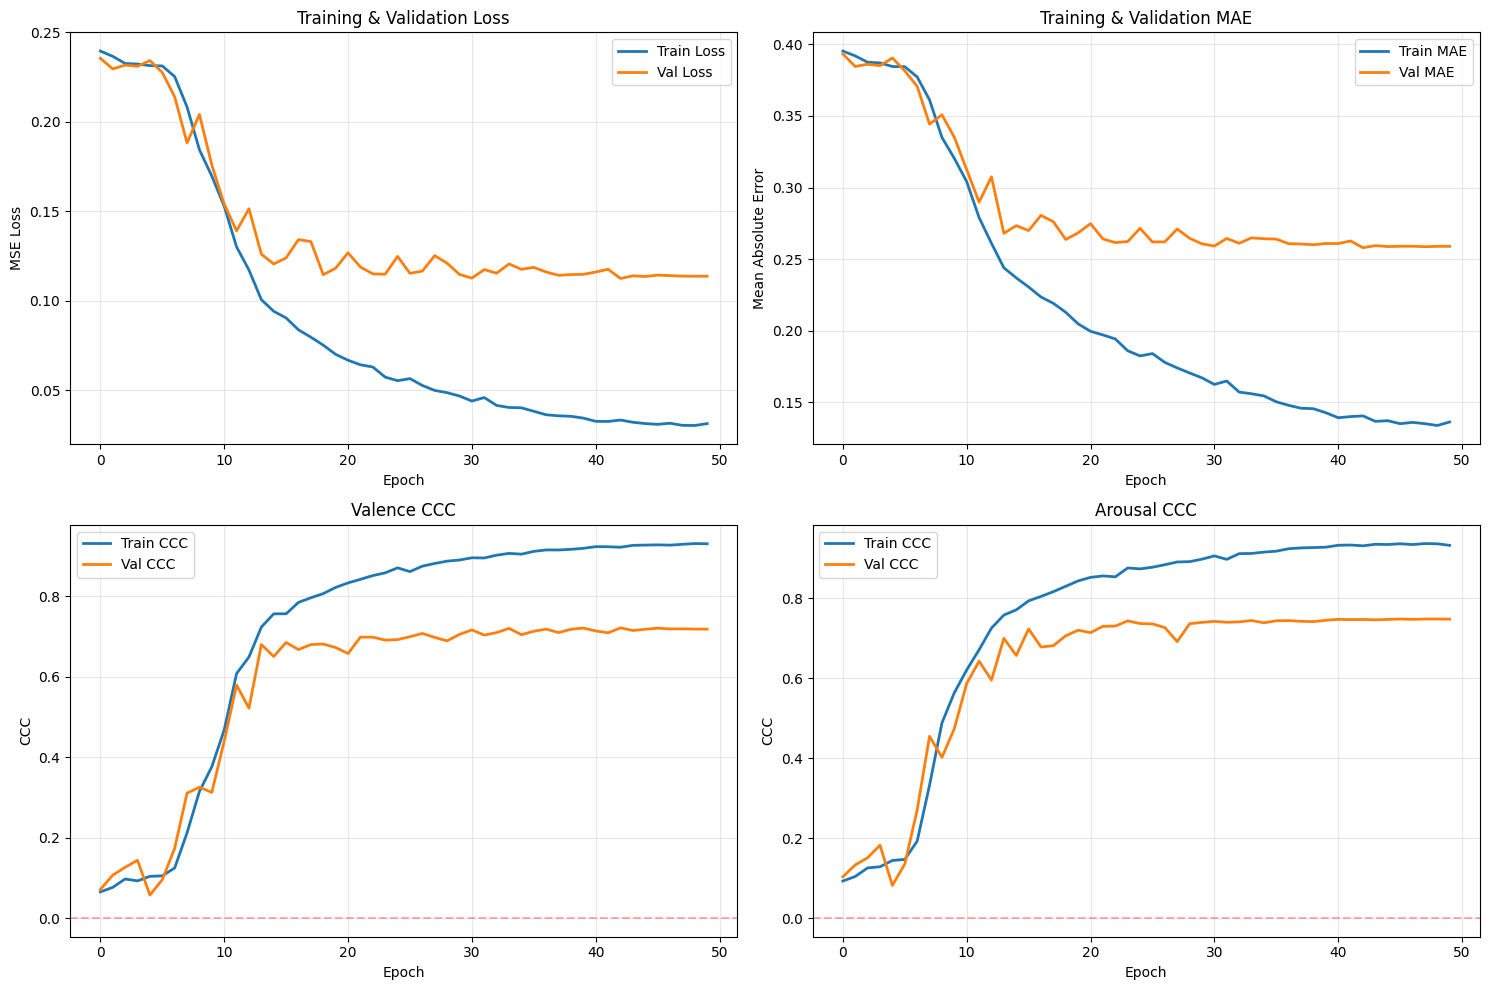

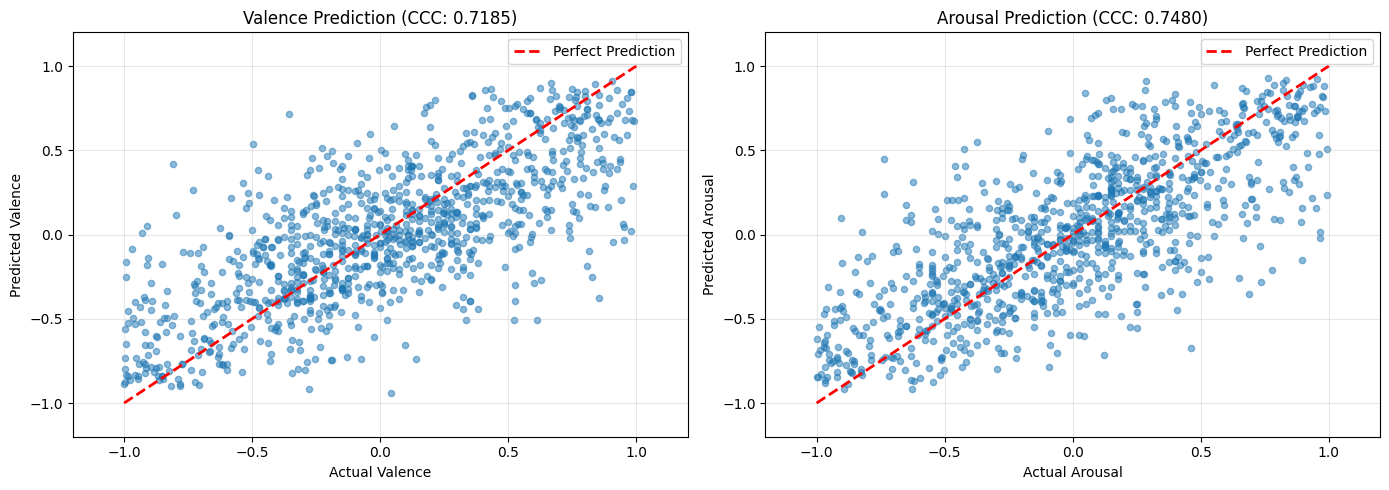

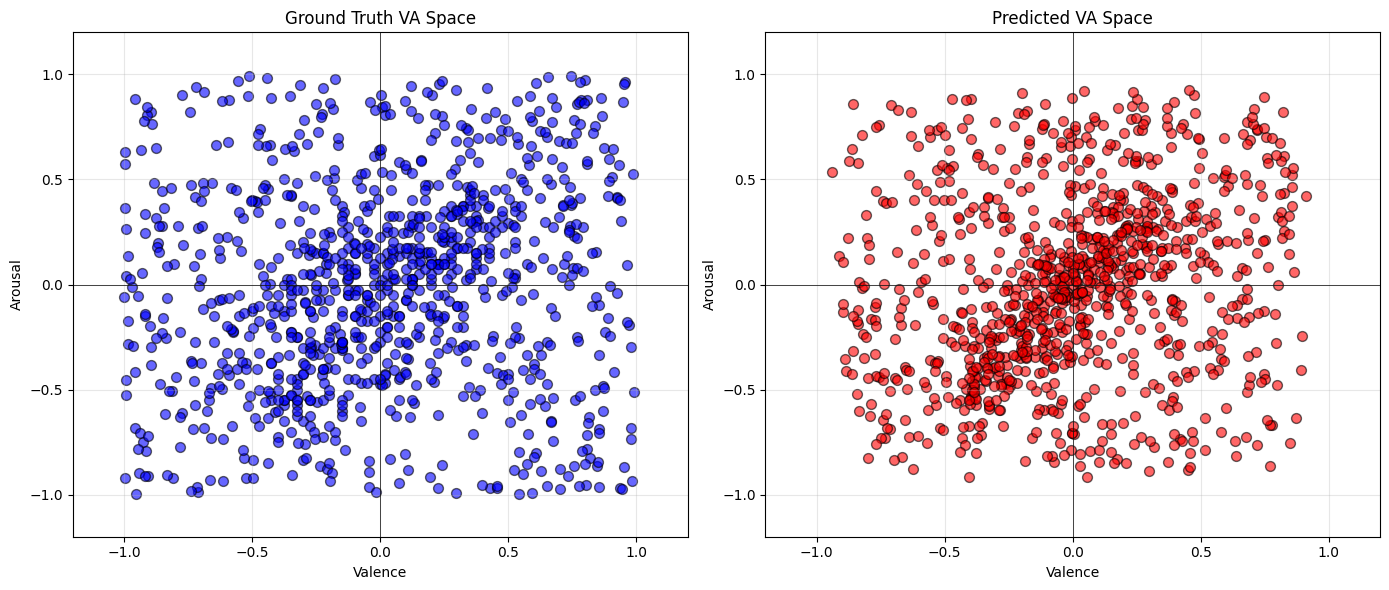


📊 FINAL RESULTS SUMMARY

🎨 GAN Augmentation:
  - Real samples: 1802
  - Synthetic samples: 3200
  - Total samples: 5002
  - Augmentation factor: 2.78x

🤖 AST Model Performance:
  - Best Val Loss: 0.1125
  - Final Val MAE: 0.2590
  - Final Val CCC Valence: 0.7185
  - Final Val CCC Arousal: 0.7480

💾 Saved Outputs:
  - Generator model: generator.pth
  - Discriminator model: discriminator.pth
  - Best AST model: best_ast_model.pth
  - Training curves: ast_training_curves.png
  - Prediction scatter: prediction_scatter.png
  - VA space comparison: va_space_comparison.png


In [32]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2 )
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MAE
axes[0, 1].plot(history['train_mae'], label='Train MAE', linewidth=2,)
axes[0, 1].plot(history['val_mae'], label='Val MAE', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Mean Absolute Error')
axes[0, 1].set_title('Training & Validation MAE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# CCC Valence
axes[1, 0].plot(history['train_ccc_v'], label='Train CCC', linewidth=2)
axes[1, 0].plot(history['val_ccc_v'], label='Val CCC', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('CCC')
axes[1, 0].set_title('Valence CCC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.3)

# CCC Arousal
axes[1, 1].plot(history['train_ccc_a'], label='Train CCC', linewidth=2)
axes[1, 1].plot(history['val_ccc_a'], label='Val CCC', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('CCC')
axes[1, 1].set_title('Arousal CCC')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'ast_training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

# Scatter plots: Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Valence
axes[0].scatter(val_labels[:, 0], val_preds[:, 0], alpha=0.5, s=20)
axes[0].plot([-1, 1], [-1, 1], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Valence')
axes[0].set_ylabel('Predicted Valence')
axes[0].set_title(f'Valence Prediction (CCC: {val_ccc_v:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(-1.2, 1.2)
axes[0].set_ylim(-1.2, 1.2)

# Arousal
axes[1].scatter(val_labels[:, 1], val_preds[:, 1], alpha=0.5, s=20)
axes[1].plot([-1, 1], [-1, 1], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Arousal')
axes[1].set_ylabel('Predicted Arousal')
axes[1].set_title(f'Arousal Prediction (CCC: {val_ccc_a:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(-1.2, 1.2)
axes[1].set_ylim(-1.2, 1.2)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'prediction_scatter.png'), dpi=150, bbox_inches='tight')
plt.show()

# 2D Valence-Arousal Space
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Ground Truth
axes[0].scatter(val_labels[:, 0], val_labels[:, 1], alpha=0.6, s=50, c='blue', edgecolors='black')
axes[0].set_xlabel('Valence')
axes[0].set_ylabel('Arousal')
axes[0].set_title('Ground Truth VA Space')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='k', linewidth=0.5)
axes[0].axvline(0, color='k', linewidth=0.5)
axes[0].set_xlim(-1.2, 1.2)
axes[0].set_ylim(-1.2, 1.2)

# Predictions
axes[1].scatter(val_preds[:, 0], val_preds[:, 1], alpha=0.6, s=50, c='red', edgecolors='black')
axes[1].set_xlabel('Valence')
axes[1].set_ylabel('Arousal')
axes[1].set_title('Predicted VA Space')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='k', linewidth=0.5)
axes[1].axvline(0, color='k', linewidth=0.5)
axes[1].set_xlim(-1.2, 1.2)
axes[1].set_ylim(-1.2, 1.2)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'va_space_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

# Final summary
print("\n" + "="*60)
print("📊 FINAL RESULTS SUMMARY")
print("="*60)
print(f"\n🎨 GAN Augmentation:")
print(f"  - Real samples: {len(real_spectrograms)}")
print(f"  - Synthetic samples: {len(synthetic_spectrograms)}")
print(f"  - Total samples: {len(all_spectrograms)}")
print(f"  - Augmentation factor: {len(all_spectrograms)/len(real_spectrograms):.2f}x")

print(f"\n🤖 AST Model Performance:")
print(f"  - Best Val Loss: {best_val_loss:.4f}")
print(f"  - Final Val MAE: {val_mae:.4f}")
print(f"  - Final Val CCC Valence: {val_ccc_v:.4f}")
print(f"  - Final Val CCC Arousal: {val_ccc_a:.4f}")

print(f"\n💾 Saved Outputs:")
print(f"  - Generator model: generator.pth")
print(f"  - Discriminator model: discriminator.pth")
print(f"  - Best AST model: best_ast_model.pth")
print(f"  - Training curves: ast_training_curves.png")
print(f"  - Prediction scatter: prediction_scatter.png")
print(f"  - VA space comparison: va_space_comparison.png")
print("="*60)

In [33]:
!zip -r /kaggle/working/output.zip /kaggle/working/augmented

  adding: kaggle/working/augmented/ (stored 0%)
  adding: kaggle/working/augmented/va_space_comparison.png (deflated 3%)
  adding: kaggle/working/augmented/discriminator.pth (deflated 8%)
  adding: kaggle/working/augmented/ast_training_curves.png (deflated 9%)
  adding: kaggle/working/augmented/best_ast_model.pth (deflated 8%)
  adding: kaggle/working/augmented/generator.pth (deflated 9%)
  adding: kaggle/working/augmented/gan_training_curves.png (deflated 24%)
  adding: kaggle/working/augmented/real_data_visualization.png (deflated 1%)
  adding: kaggle/working/augmented/prediction_scatter.png (deflated 3%)
  adding: kaggle/working/augmented/augmented_dataset_comparison.png (deflated 2%)
  adding: kaggle/working/augmented/real_vs_synthetic_spectrograms.png (deflated 0%)
